# Stroke prediction

A stroke occurs when blood supply to part of the brain is interrupted or reduced, mainly due to blockage or rupture of an artery, which then prevents brain tissue from getting oxygen and nutrients.

According to the World Health Organization (WHO), stroke is the 3rd leading cause of disability globally, and responsible for approximately 11% of global deaths. In the United States alone, nearly 800,000 people suffer from a stroke every year, with about three in four being first-time strokes. And since strokes can be prevented in about 80% of the time, educating the general population on stroke signs is paramount.

The objective of this study was to build a model for predicting the likelihood of having a stroke based on several clinical inputs (such as age, disease and smoking status).

Used database: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset.

This dataset is comprised of 5110 rows corresponding to patients and the following columns:

1.  id                : unique identifier
2.  gender            : "Male", "Female" or "Other"
3.  age               : age of the patient
4.  hypertension      : 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5.  heart_disease     : 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6.  ever_married      : "No" or "Yes"
7.  work_type         : "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8.  Residence_type    : "Rural" or "Urban"
9.  avg_glucose_level : average glucose level in blood
10. bmi               : body mass index
11. smoking_status    : "formerly smoked", "never smoked", "smokes" or "Unknown"
12. stroke            : 0 the patient did not have a stroke, and 1 if the patient had a stroke

## 1. Importing libraries and loading the dataset

In [1]:
# to import the libraries that are going to be needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set()

In [2]:
# load the dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# setting id as our index
df.set_index('id', inplace=True)
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


In [4]:
# to check general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


## 2. Data cleaning

From the general information about the dataset, we can observe that there are missing values in the BMI column. Now let's check how many of them.

In [5]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

With this we can observe that all 201 NaN values are from the BMI column. One option to deal with missing values is to simply drop them if we have a big enough dataset. In our case, because we have an unevenly distributed dataset (as more people didn't have a stroke), and since we know from the medical literature that BMI is not dependent on age or sex, we will fill all NaN values with the BMI average. 

In [6]:
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [7]:
# to group by gender
group = df.groupby(['gender'])
group.describe()

age                                                       \
         count       mean        std    min   25%   50%   75%   max   
gender                                                                
Female  2994.0  43.757395  21.966561   0.08  27.0  44.0  61.0  82.0   
Male    2115.0  42.483385  23.484066   0.08  22.0  46.0  61.0  82.0   
Other      1.0  26.000000        NaN  26.00  26.0  26.0  26.0  26.0   

       hypertension            ...   bmi        stroke                      \
              count      mean  ...   75%   max   count      mean       std   
gender                         ...                                           
Female       2994.0  0.092184  ...  33.3  78.0  2994.0  0.047094  0.211876   
Male         2115.0  0.104965  ...  32.2  97.6  2115.0  0.051064  0.220180   
Other           1.0  0.000000  ...  22.4  22.4     1.0  0.000000       NaN   

                                 
        min  25%  50%  75%  max  
gender                           
Female  0.0  0.0  0.0  0.0  1.0  
Male    0.0  0.0  0.0  0.0  1.0  
Other   0.0  0.0  0.0  0.0  0.0  

[3 rows x 48 columns]

From this we can see that we only have one patient with gender = 'other'. Since we can't make any inferences with n = 1, we will simply drop this row.

In [8]:
# to delete a row that contains 'Other' on the column gender
df1 = df[~df.gender.str.contains("Other")]

In [9]:
# to check if the gender = other has been deleted
group_df1 = df1.groupby(['gender'])
group_df1.describe()

age                                                      \
         count       mean        std   min   25%   50%   75%   max   
gender                                                               
Female  2994.0  43.757395  21.966561  0.08  27.0  44.0  61.0  82.0   
Male    2115.0  42.483385  23.484066  0.08  22.0  46.0  61.0  82.0   

       hypertension            ...   bmi        stroke                      \
              count      mean  ...   75%   max   count      mean       std   
gender                         ...                                           
Female       2994.0  0.092184  ...  33.3  78.0  2994.0  0.047094  0.211876   
Male         2115.0  0.104965  ...  32.2  97.6  2115.0  0.051064  0.220180   

                                 
        min  25%  50%  75%  max  
gender                           
Female  0.0  0.0  0.0  0.0  1.0  
Male    0.0  0.0  0.0  0.0  1.0  

[2 rows x 48 columns]

In [10]:
# double-checking if we still have any null values
df1.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Now that we have cleaned the dataset, we can proceed to visualize our data.

## 3. Exploratory data analysis

### 3.1 Age

To make if easier to visualize the possible relationship between age and the incidence of strokes, let's first create a new column for age groups and assign our patients to those groups depending on their age.

In [11]:
# create empty column for age_group
df1['age group'] = ''
df1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
id,,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,


In [12]:
# create age groups to fill up that column

df1.loc[(df1.age <= 4),  'age group'] = '0-04'
df1.loc[(df1.age >= 5) & (df1.age < 10),  'age group'] = '05-09'
df1.loc[(df1.age >= 10) & (df1.age < 15),  'age group'] = '10-14'
df1.loc[(df1.age >= 15) & (df1.age < 20),  'age group'] = '15-19'
df1.loc[(df1.age >= 20) & (df1.age < 30),  'age group'] = '20-29'
df1.loc[(df1.age >= 30) & (df1.age < 40),  'age group'] = '30-39'
df1.loc[(df1.age >= 40) & (df1.age < 50),  'age group'] = '40-49'
df1.loc[(df1.age >= 50) & (df1.age < 60),  'age group'] = '50-59'
df1.loc[(df1.age >= 60) & (df1.age < 70),  'age group'] = '60-69'
df1.loc[(df1.age >= 70) & (df1.age < 80),  'age group'] = '70-79'
df1.loc[(df1.age >= 80) & (df1.age < 90),  'age group'] = '80-89'
df1.loc[(df1.age >= 90) & (df1.age < 100),  'age group'] = '90-99'

df1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
id,,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,60-69
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1,60-69
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,80-89
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,40-49
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,70-79


Now let's visualize the possible relationships between the patient's age and the incidence of strokes. We will do that using a 100% stacked bar chart between the two variables.

Text(0.5, 1.0, 'Incidence of stroke per age group')

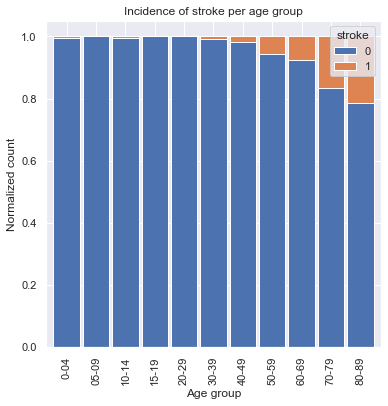

In [13]:
df1.groupby('age group')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Age group")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke per age group')

With this graph we can observe that the risk of experiencing a stroke seems to increase with age, as more people in the age group 80-89 had the highest prevalence of strokes.

### 3.2 BMI

Text(0.5, 1.0, 'Incidence of stroke x BMI')

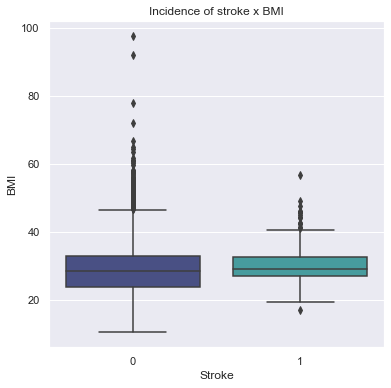

In [14]:
# To create the figure and setting the dimensions
fig, ax = plt.subplots(figsize=(6,6))

# To create the boxplot for stroke and BMI
ax = sns.boxplot(x='stroke', y='bmi', data=df1, palette = 'mako')
ax.set_xlabel('Stroke')
ax.set_ylabel('BMI')
ax.set_title('Incidence of stroke x BMI')

Here we can observe that BMI does not seem to impact the incidence of strokes.

### 3.3 Average glucose levels

Text(0.5, 1.0, 'Incidence of stroke x average glucose level')

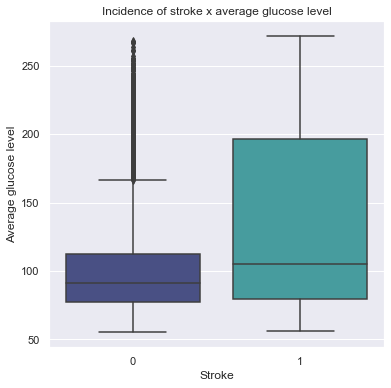

In [15]:
# To create the figure and setting the dimensions
fig, ax = plt.subplots(figsize=(6,6))

# To create the boxplot for stroke and BMI
ax = sns.boxplot(x='stroke', y='avg_glucose_level', data=df1, palette = 'mako')
ax.set_xlabel('Stroke')
ax.set_ylabel('Average glucose level')
ax.set_title('Incidence of stroke x average glucose level')

With this graph we can infer that patients that had a stroke, also had higher levels of glucose in their blood.

### 3.4 Hypertension

Text(0.5, 1.0, 'Incidence of stroke x hypertension')

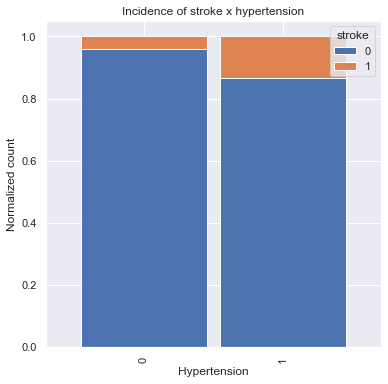

In [16]:
df1.groupby('hypertension')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Hypertension")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke x hypertension')

Looking at this graph we can observe that a higher proportion of patients who suffered from hypertension also experienced a stroke.

### 3.5 Heart disease

Text(0.5, 1.0, 'Incidence of stroke x heart disease')

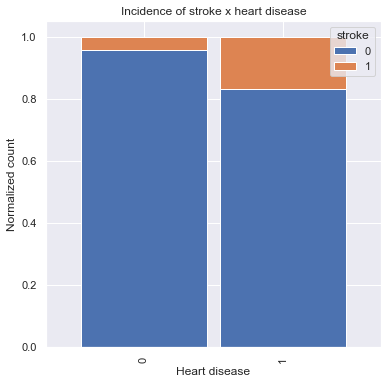

In [17]:
df1.groupby('heart_disease')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Heart disease")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke x heart disease')

Similarly with hypertension, a higher proportion of patients who suffered from a heart disease also had a stroke.

### 3.6 Smoking status

Text(0.5, 1.0, 'Incidence of stroke x smoking status')

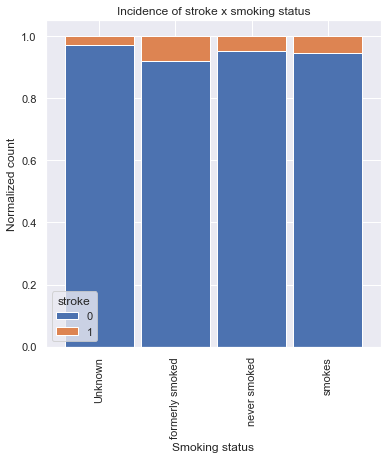

In [18]:
df1.groupby('smoking_status')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Smoking status")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke x smoking status')

As for the smoking status, the group comprising people who formerly smoked seemed to had the higher proportion of people who suffered a stroke.

### 3.7 Gender

Text(0.5, 1.0, 'Incidence of stroke x gender')

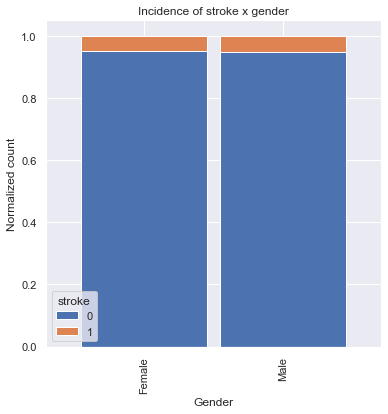

In [19]:
df1.groupby('gender')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Gender")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke x gender')

As for gender, it doesn't seem to affect the chances of having a stroke, as the proportion of patients who had a stroke was similar between males and females.

### 3.8 Residence type

Text(0.5, 1.0, 'Incidence of stroke x residence type')

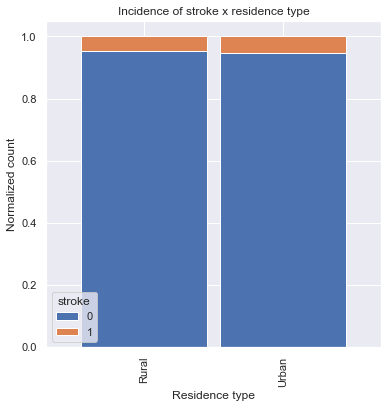

In [20]:
df1.groupby('Residence_type')['stroke'].value_counts(normalize=True).unstack('stroke').plot.bar(stacked=True, figsize = (6,6), width = 0.9)
plt.xlabel("Residence type")
plt.ylabel("Normalized count")
plt.title('Incidence of stroke x residence type')

Similarly with gender, residence type also doesn't seem to be affect the chances of having a stroke.

Finally, from our preliminary analysis using EDA, we can infer that:

a) Older patients suffered more strokes than their younger counterparts;

b) Higher BMI does not appear to increase the risk of having a stroke;

c) Patients who had higher levels of glucose in their blood also had more strokes;

d) A higher proportion of patients who suffered from hypertension or heart disease experienced a stroke;

e) People who formely smoked were the group with the higher percentage of strokes;

f) The likelihood of having a stroke was not impacted by the patient's gender or residence type.

## 4. Correlation between clinical features

In order to be able to perform a correlation between the clinical features, we first need to transform our categorical values into 0s and 1s. For this, we will use LabelEncoder from sklearn. Label Encoder is a technique that will convert categorical data into numeric data by taking the value and converting it into numeric data from 0 to n-1.

In [21]:
# First, let's create a copy of our dataframe
df2 = df1.copy()

In [22]:
# To import the sklearn package
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df2['gender'] = le.fit_transform(df2['gender'])
df2['ever_married'] = le.fit_transform(df2['ever_married'])
df2['work_type'] = le.fit_transform(df2['work_type'])
df2['Residence_type'] = le.fit_transform(df2['Residence_type'])
df2['smoking_status'] = le.fit_transform(df2['smoking_status'])

df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age group
id,,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1,60-69
51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1,60-69
31112,1,80.0,0,1,1,2,0,105.92,32.500000,2,1,80-89
60182,0,49.0,0,0,1,2,1,171.23,34.400000,3,1,40-49
1665,0,79.0,1,0,1,3,0,174.12,24.000000,2,1,70-79


The age group was useful for visualizing the relationship between age and the incidence of stroke, but for the correlation we should use either "age" or "age group", so we're going to drop the later.

In [23]:
df3 = df2.drop(['age group'], axis = 1)
df3.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
51676,0,61.0,0,0,1,3,0,202.21,28.893237,2,1


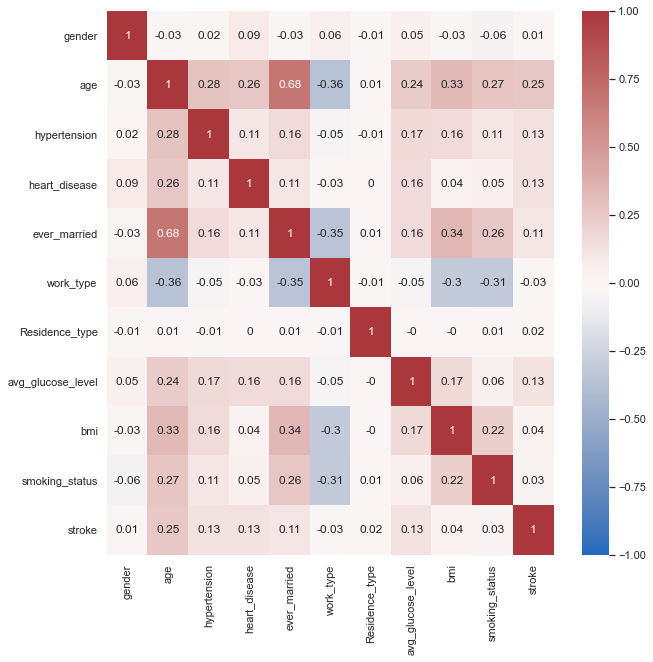

In [24]:
# To create the correlation and plot it as a heatmap
corr = df3.corr().round(2)
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot = True, cmap = 'vlag', vmin=-1, vmax=1);

From this heatmap, we can observe that the "ever_married" and "age" columns have a positive correlation of 0.68, meaning that the two variables move in the same direction. And since age gives us more information than knowing if a patient is married or not, we can confidently drop the "ever_married" column.

In [25]:
df4 = df3.drop(['ever_married'], axis = 1)
df4.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,
9046,1,67.0,0,1,2,1,228.69,36.600000,1,1
51676,0,61.0,0,0,3,0,202.21,28.893237,2,1
31112,1,80.0,0,1,2,0,105.92,32.500000,2,1
60182,0,49.0,0,0,2,1,171.23,34.400000,3,1
1665,0,79.0,1,0,3,0,174.12,24.000000,2,1


## 5. Final preprocessing

For the models, we are going to use "x" and "y" as our predictor and target variables, respectively.

In [26]:
# for x, we need the values besides stroke
X = df4.drop(['stroke'], axis = 1)

# for y, we only need the column stroke
y = df4['stroke']

Now, let's split our data intro train and test data. For this we will need to import train_test_split from sklearn.

In [27]:
# importing train_test_split
from sklearn.model_selection import train_test_split

seed = 1234

# spliting our dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4087, 9) (1022, 9) (4087,) (1022,)


Before creating models to try to predict stroke occurence based on clinical features, we need to normalize our numerical features (‘avg_glucose_level’,’bmi’ and ‘age’) so they contribute equally to the model and don't create bias. This needs to be done since each one of those features is measured in a different scale, and therefore will not give equal contribution to the analysis.

For this, we will use the min-max approach on the training dataset. The min-max approach will subtracts the minimum value of the feature and then divides it by the range. With this we get values between 0 and 1.

In [28]:
# import package
from sklearn.preprocessing import MinMaxScaler

# assign MinMaxScaler() to min_max_scaler
min_max_scaler = MinMaxScaler()


# fit and transform the training and test datasets sepparetly
X_train[["avg_glucose_level", "bmi", "age"]] = min_max_scaler. fit_transform(X_train[["avg_glucose_level", "bmi", "age"]])
X_test[["avg_glucose_level", "bmi", "age"]] = min_max_scaler. transform(X_test[["avg_glucose_level", "bmi", "age"]])

X_train.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,
61000,0,0.841309,0,1,2,1,0.661112,0.371134,3
31092,0,0.365234,0,0,2,1,0.154372,0.400916,2
17771,0,0.780273,1,0,0,1,0.720155,0.134021,2
3178,0,0.304199,0,0,2,0,0.063060,0.513173,1
12175,0,0.658203,0,0,2,1,0.228003,0.194731,3


## 6. Modeling

We will now explore 3 algorithms to check which produces reliable and repeatable results. The algorithms are:

* Logistic regression
* Decision trees
* Naive Bayes

Let's start by importing the correct libraries

In [29]:
# importing the correct libraries for the models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# importing the library for evaluation
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn import tree

### Logistic regression

In [30]:
# fit the train datasets in our logistic regression
log_model = linear_model.LogisticRegression(solver='liblinear')
log_model.fit(X_train,y_train)

# print accuracy for training and test sets

print("Logistic regression:")
print(f"Training accuracy: {log_model.score(X_train,y_train)}")
print(f"Test accuracy: {log_model.score(X_test, y_test)}")

Logistic regression:
Training accuracy: 0.9517983851235625
Test accuracy: 0.9500978473581213


### Naive Bayes

In [31]:
# fit the train datasets in our Naive Bayes analysis
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)

# print accuracy for training and test sets

print("Naive Bayes:")
print(f"Training accuracy: {nb_model.score(X_train,y_train)}")
print(f"Test accuracy: {nb_model.score(X_test, y_test)}")

Naive Bayes:
Training accuracy: 0.8781502324443357
Test accuracy: 0.8610567514677103


### Decision tree

In [32]:
# fit the train datasets in our Decision tree analysis
tree_model = tree.DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train,y_train)

# print accuracy for training and test sets

print("Decision tree:")
print(f"Training accuracy: {tree_model.score(X_train,y_train)}")
print(f"Test accuracy: {tree_model.score(X_test, y_test)}")

Decision tree:
Training accuracy: 0.9562025935894299
Test accuracy: 0.9452054794520548


Looking at the training and test accuracies for the models above, we can observe that Logistic Regression and Decision Tree were the models with higher training and test accuracy scores.

## 7. Cross validation

### Logistic regression

In [36]:
# import libraries
from sklearn.model_selection import cross_val_score

# to create a variable for the logistic regression model
log_model = linear_model.LogisticRegression(solver='liblinear')

# to get the cross validation scores for the logistic regression
scores_log = cross_val_score(log_model, X_train, y_train, cv = 10, scoring='accuracy')

# to print the results
print('Cross validation score for logistic regression: {}'.format(scores_log.mean()))

Cross validation score for logistic regression: 0.9517989836521406


### Decision tree

In [37]:
# to create a variable for the decision tree model
tree_model = tree.DecisionTreeClassifier(max_depth=5)

# to get the cross validation scores for the logistic regression
scores_tree = cross_val_score(tree_model, X_train, y_train, cv = 10, scoring='accuracy')

# to print the results
print('Cross validation score for decision tree: {}'.format(scores_tree.mean()))

Cross validation score for decision tree: 0.9491106956229924


Using the mean cross-validation, we can conclude that we expect the Logistic Regression model to be around 95.18% accurate on average, while the Decision tree model is around 94.91% accurate.

## 8. References

BMI dependence on age and sex - https://www.cdc.gov/obesity/downloads/bmiforpactitioners.pdf